<a href="https://colab.research.google.com/github/federico-bassi/market_basket_analysis/blob/main/amd_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market-basket Analysis
This notebook contains the code necessary to produce the Market Basket Analysis for the project "Algorithms for Massive Datasets".

## Setup

In [1]:
import pandas as pd
import numpy as np
import itertools
from nltk import word_tokenize
from google.colab import drive 
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import zipfile
import seaborn as sns

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

In [4]:
!pip install -q findspark
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

### Retrieve the dataset

In [6]:
os.environ['KAGGLE_USERNAME'] = "federicobassi1999"
os.environ['KAGGLE_KEY'] = "58442c0b245995de84ca59d6ddb81d63"
!kaggle datasets download -d xhlulu/medal-emnlp --unzip

100% 6.82G/6.82G [00:59<00:00, 147MB/s]
100% 6.82G/6.82G [00:59<00:00, 124MB/s]


In [25]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType

# Specify the schema
schema = StructType([
    StructField("TEXT", StringType()),
    StructField("LOCATION", StringType()),
    StructField("LABEL", StringType())
])

# Retrieve the datase
df = spark.read.csv("full_data.csv", schema=schema, header=True, sep=",")

# Select the column "text"
df = df.select("TEXT")

In [30]:
# Take a random sample (allows feasible computational time)
subset = df.sample(False, 0.001, seed=42)

In [31]:
# Convert the dataframe to rdd and take the column "text"
rdd = subset.rdd.map(lambda x: x[0])

## Data Preprocessing

In [32]:
subset.count()

14333

In [33]:
subset.take(1)

['alphabisabolol has a primary antipeptic action depending on dosage which is not caused by an alteration of the phvalue the proteolytic activity of pepsin is reduced by percent through addition of bisabolol in the ratio of the antipeptic action of bisabolol only occurs in case of direct contact in case of a previous contact with the ATP the inhibiting effect is lost']

In [ ]:
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required nltk data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define the function for preprocessing text
def preprocess(row):
    from nltk.corpus import stopwords
    # Convert the text to lowercase
    text = row.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    # Tokenize
    word_tokens = word_tokenize(text)
    filtered_words = [word for word in word_tokens if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    # Return the preprocessed text as a list of unique words
    return list(set(lemmatized_words))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Preprocess
rdd = rdd.map(preprocess)

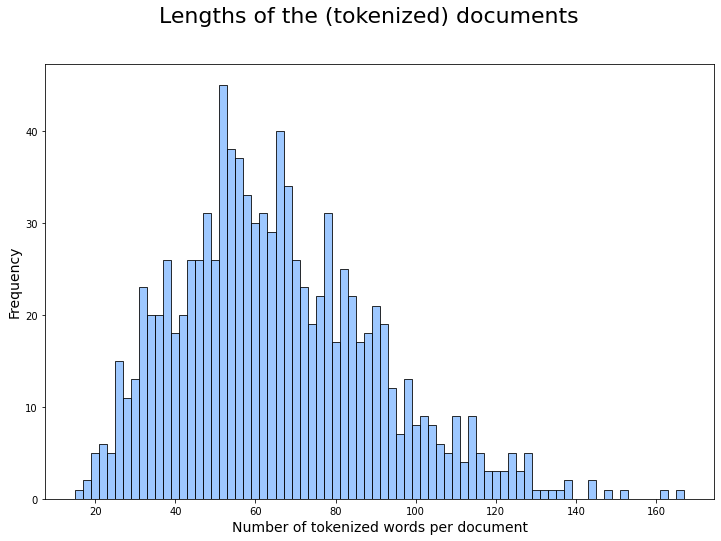

In [ ]:
# Plot the lengths of the tokenized documents
lengths = rdd.map(len).collect()

f, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=lengths, binwidth=2, ax=ax, color='#7EB6FF')
ax.set_xlabel("Number of tokenized words per document", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
f.suptitle("Lengths of the (tokenized) documents", fontsize=22)
plt.savefig("drive/MyDrive/amd_proj/histogram.jpeg")
plt.show()

In [ ]:
def create_vocabulary(rdd):

    # Assign a index to each word
    integer2word = rdd.flatMap(lambda line:line)\
                      .distinct().zipWithIndex()\
                      .map(lambda x: (x[1], x[0]))\
                      .collectAsMap()

    # Reverse the key, value pairs
    word2integer = {value:key for key, value in integer2word.items()}

    return integer2word, word2integer

In [ ]:
# Create the vocabularies
integer2word, word2integer = create_vocabulary(rdd)

In [ ]:
# Substitute each word by its corresponding index
def create_indexing(rdd, vocab):
 return rdd.map(lambda sentence: [vocab[word] for word in sentence])

In [ ]:
rdd = create_indexing(rdd, word2integer)

## Algorithm Implementation

### Step-by-step implementation

In [ ]:
# Define a threshold
threshold = rdd.count()*0.1
threshold

In [ ]:
# Define a list for the final output
results = []

In [ ]:
# Compute frequent singletons
frequent_singletons = rdd.flatMap(lambda sentence: [(word, 1) for word in sentence])\
        .reduceByKey(lambda w1, w2: w1+w2)\
        .filter(lambda t: t[1]>threshold)

In [ ]:
frequent_singletons.take(5)

[(2, 301), (6334, 323), (18, 132), (24, 105), (6348, 131)]

In [ ]:
len(frequent_singletons.collect())

57

In [ ]:
# Add frequent singletons to result
results += frequent_singletons.collect()

In [ ]:
# Discard the counter
frequent_singletons = frequent_singletons.map(lambda t: t[0])

In [ ]:
# Comput candidates for next iteration by computing the cartesian product between
# the list of frequent singletons and itself. Discard the couples with the same 
# element repeated and couples with same elements in different order

candidates = frequent_singletons.cartesian(frequent_singletons)\
                                .filter(lambda t: len(set(t))==len(t))\
                                .map(lambda t: tuple(sorted(t)))\
                                .distinct()\
                                .collect()

In [ ]:
candidates[1:6]

[(2, 6348), (2, 6364), (2, 36), (2, 6420), (2, 6492)]

In [ ]:
# Compute frequent pairs

frequent_pairs = rdd.flatMap(lambda sentence: [(tuple(candidate), 1) for candidate in candidates if set(candidate).issubset(set(sentence))])\
                    .reduceByKey(lambda t1,t2: t1+t2)\
                    .filter(lambda t: t[1]>threshold)

In [ ]:
frequent_pairs.take(5)

[((2, 6334), 111),
 ((6334, 6402), 178),
 ((61, 6485), 115),
 ((147, 6485), 145),
 ((43, 6485), 133)]

In [ ]:
len(frequent_pairs.collect())

10

In [ ]:
results+=frequent_pairs.collect()

In [ ]:
len(results)

67

In [ ]:
# Discard the count
frequent_pairs = frequent_pairs.map(lambda t: t[0])

In [ ]:
# Compute pairs for next iteration
candidates = frequent_pairs.cartesian(frequent_pairs)\
                          .map(lambda tuples: {item for tupla in tuples for item in tupla})\
                          .filter(lambda t: len(t) == 3)\
                          .map(lambda t: tuple(sorted(t)))\
                          .distinct()\
                          .collect()

In [ ]:
candidates[1:6]

[(43, 61, 6485),
 (2, 147, 6334),
 (2, 6334, 6485),
 (6334, 6402, 6485),
 (2, 6462, 6485)]

In [ ]:
# Compute frequent triples
frequent_triples = rdd.flatMap(lambda sentence: [(tuple(candidate), 1) for candidate in candidates if set(candidate).issubset(set(sentence))])\
                    .reduceByKey(lambda t1,t2: t1+t2)\
                    .filter(lambda t: t[1]>threshold)

In [ ]:
frequent_triples.take(1)

[((6334, 6402, 6485), 108)]

In [ ]:
len(frequent_triples.collect())

1

In [ ]:
results += frequent_triples.collect()

In [ ]:
frequent_triples = frequent_triples.map(lambda t: t[0])

In [ ]:
results

[(2, 301),
 (6334, 323),
 (18, 132),
 (24, 105),
 (6348, 131),
 (6364, 104),
 (36, 131),
 (58, 160),
 (66, 169),
 (6402, 262),
 (6420, 103),
 (6442, 198),
 (6462, 235),
 (146, 106),
 (6486, 123),
 (6492, 165),
 (6514, 170),
 (6516, 104),
 (6538, 103),
 (200, 173),
 (210, 180),
 (224, 101),
 (6600, 108),
 (326, 142),
 (6660, 104),
 (6788, 109),
 (762, 126),
 (6347, 122),
 (29, 235),
 (6349, 125),
 (6353, 156),
 (6361, 103),
 (6365, 120),
 (37, 109),
 (43, 230),
 (6381, 213),
 (61, 168),
 (63, 191),
 (65, 166),
 (6399, 125),
 (6417, 112),
 (75, 125),
 (6427, 167),
 (6449, 170),
 (111, 130),
 (147, 262),
 (6485, 412),
 (6501, 120),
 (201, 122),
 (215, 128),
 (229, 114),
 (6577, 128),
 (6607, 102),
 (6615, 156),
 (6631, 140),
 (6687, 110),
 (7051, 114),
 ((2, 6334), 111),
 ((6334, 6402), 178),
 ((61, 6485), 115),
 ((147, 6485), 145),
 ((43, 6485), 133),
 ((2, 147), 107),
 ((2, 6485), 136),
 ((6462, 6485), 132),
 ((6402, 6485), 145),
 ((6334, 6485), 165),
 ((6334, 6402, 6485), 108)]

In [ ]:
# Re-convert the indexes
results = [(integer2word[t[0]],t[1]) if type(t[0])==int else (tuple([integer2word[element] for element in t[0]]),t[1]) for t in results]

In [ ]:
results

[('effect', 301),
 ('activity', 323),
 ('obtained', 132),
 ('t3', 105),
 ('condition', 131),
 ('well', 104),
 ('different', 131),
 ('rate', 160),
 ('increased', 169),
 ('enzyme', 262),
 ('inhibition', 103),
 ('also', 198),
 ('acid', 235),
 ('compared', 106),
 ('could', 123),
 ('cell', 165),
 ('studied', 170),
 ('present', 104),
 ('decreased', 103),
 ('increase', 173),
 ('change', 180),
 ('substrate', 101),
 ('weight', 108),
 ('may', 142),
 ('method', 104),
 ('decrease', 109),
 ('isolated', 126),
 ('rat', 122),
 ('result', 235),
 ('blood', 125),
 ('one', 156),
 ('property', 103),
 ('time', 120),
 ('molecular', 109),
 ('c', 230),
 ('found', 213),
 ('value', 168),
 ('two', 191),
 ('presence', 166),
 ('inhibited', 125),
 ('level', 112),
 ('used', 125),
 ('observed', 167),
 ('study', 170),
 ('similar', 130),
 ('concentration', 262),
 ('ph', 412),
 ('patient', 120),
 ('high', 122),
 ('showed', 128),
 ('group', 114),
 ('reaction', 128),
 ('purified', 102),
 ('protein', 156),
 ('degree', 140),

### Generalized implementation

In [34]:
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required nltk data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define the function for preprocessing text
def preprocess(row):
    from nltk.corpus import stopwords
    # Convert the text to lowercase
    text = row.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    # Tokenize
    word_tokens = word_tokenize(text)
    filtered_words = [word for word in word_tokens if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    # Return the preprocessed text as a list of unique words
    return list(set(lemmatized_words))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [35]:
def create_vocabulary(rdd):

    # Assign a index to each word
    integer2word = rdd.flatMap(lambda line:line)\
                      .distinct().zipWithIndex()\
                      .map(lambda x: (x[1], x[0]))\
                      .collectAsMap()

    # Reverse the key, value pairs
    word2integer = {value:key for key, value in integer2word.items()}

    return integer2word, word2integer

In [36]:
def create_indexing(rdd, vocab):
 return rdd.map(lambda sentence: [vocab[word] for word in sentence])

In [37]:
"""
    Generate frequent itemsets using the Apriori algorithm.
    
    Inputs:
        rdd (DataFrame): The input rdd containing the data to be analyzed.
        perc_threshold (float): The threshold percentage of frequency below which an item is pruned.
        max_itemset_size (int): The maximum size of the itemset to generate. If None, no limit is imposed.
    
    Returns:
        list: A list of frequent itemsets.
    """

def apriori(rdd, perc_threshold=.01, max_itemset_size = "none"):
  # Compute the threshold on the basis of the percentage received as argument
  threshold = rdd.count()*perc_threshold
  
  # Preprocess the rdd
  rdd = rdd.map(preprocess)

  # Create the vocabularies: word2integer and integer2word
  integer2word, word2integer = create_vocabulary(rdd)

  # Index the rdd
  rdd = create_indexing(rdd, word2integer)

  # Define a counter, a flag, a list for storing the results and for storing the candidates
  iterate = True
  results = []
  candidates = []

  # Compute frequent singletons
  frequent_singletons = rdd.flatMap(lambda sentence: [(word, 1) for word in sentence])\
        .reduceByKey(lambda w1, w2: w1+w2)\
        .filter(lambda t: t[1]>threshold)

  # Add the frequent singletons to the result
  results += frequent_singletons.collect()

  # Remove the count
  frequent_singletons = frequent_singletons.map(lambda t:t[0])

  # Comput candidates for next iteration by computing the cartesian product between
  # the list of frequent singletons and itself. Discard the couples with the same 
  # element repeated and couples with same elements in different order
  candidates = frequent_singletons.cartesian(frequent_singletons)\
                                .filter(lambda t: len(set(t))==len(t))\
                                .map(lambda t: tuple(sorted(t)))\
                                .distinct()\
                                .collect()
  
  # Define the candidate size, starting from triples
  candidate_size = 3

  while iterate:
    
    # If the maximum itemset size is 1, exit the loop
    if max_itemset_size ==1:
      break
  
    # Filtering Phase
    frequent_k_itemset = rdd.flatMap(lambda sentence: [(tuple(candidate), 1) for candidate in candidates if set(candidate).issubset(set(sentence))])\
                    .reduceByKey(lambda t1,t2: t1+t2)\
                    .filter(lambda t: t[1]>threshold)

    # Add the filtered items to the result list
    results += frequent_k_itemset.collect()

    # Remove the count
    frequent_k_itemset = frequent_k_itemset.map(lambda t:t[0])

    # Compute candidates for the next iteration  
    candidates = frequent_k_itemset.cartesian(frequent_k_itemset)\
                          .map(lambda tuples: {item for tupla in tuples for item in tupla})\
                          .filter(lambda t: len(t) == candidate_size)\
                          .map(lambda t: tuple(sorted(t)))\
                          .distinct()\
                          .collect()

    # Iterate until the candidate set is empty or the max itemset size has been reached
    if ((max_itemset_size=="none") and (len(candidates) == 0)) or ((max_itemset_size != "none") and (candidate_size-1 == max_itemset_size)):
      iterate = False

    candidate_size += 1
    
  return [(integer2word[t[0]],t[1]) if type(t[0])==int else (tuple([integer2word[element] for element in t[0]]),t[1]) for t in results]

In [ ]:
results = apriori(subset, 0.03)

In [ ]:
results

[('case', 99),
 ('alteration', 34),
 ('effect', 301),
 ('action', 67),
 ('atp', 94),
 ('caused', 79),
 ('addition', 98),
 ('reduced', 94),
 ('activity', 323),
 ('obtained', 132),
 ('since', 45),
 ('min', 67),
 ('t3', 105),
 ('show', 86),
 ('condition', 131),
 ('determined', 100),
 ('use', 63),
 ('well', 104),
 ('different', 131),
 ('thus', 65),
 ('test', 45),
 ('rate', 160),
 ('either', 100),
 ('increased', 169),
 ('enzyme', 262),
 ('whereas', 77),
 ('animal', 73),
 ('liver', 74),
 ('higher', 98),
 ('inhibition', 103),
 ('three', 97),
 ('mouse', 44),
 ('due', 99),
 ('le', 95),
 ('metabolism', 31),
 ('brain', 35),
 ('also', 198),
 ('order', 61),
 ('contains', 33),
 ('equal', 40),
 ('acid', 235),
 ('even', 44),
 ('measured', 94),
 ('first', 67),
 ('active', 84),
 ('carried', 39),
 ('compared', 106),
 ('mean', 71),
 ('could', 123),
 ('factor', 62),
 ('observation', 37),
 ('cell', 165),
 ('extent', 40),
 ('clinical', 47),
 ('markedly', 36),
 ('serum', 63),
 ('activation', 45),
 ('previousl

## Experiments

### Computational time as a function of max itemset size

In [ ]:
from time import time
import statistics

In [ ]:
sizes = [1,2,3,4,"none"]
thresholds = [0.04, 0.05, 0.06]
timings = {}

for threshold in thresholds:
  print(f"Threshold: {threshold}")
  durations = []
  for size in sizes:
    print(f"\nMax itemsize: {size}")
    start_time = time()
    result = apriori(subset, max_itemset_size=size, perc_threshold=threshold)
    end_time = time()
    durations.append(end_time-start_time)
  timings[threshold] = durations
  print("====================\n")

Threshold: 0.04

Max itemsize: 1

Max itemsize: 2
Computing candidate size 3

Max itemsize: 3
Computing candidate size 3
Computing candidate size 4

Max itemsize: 4
Computing candidate size 3
Computing candidate size 4
Computing candidate size 5

Max itemsize: none
Computing candidate size 3
Computing candidate size 4
Computing candidate size 5
Computing candidate size 6

Threshold: 0.05

Max itemsize: 1

Max itemsize: 2
Computing candidate size 3

Max itemsize: 3
Computing candidate size 3
Computing candidate size 4

Max itemsize: 4
Computing candidate size 3
Computing candidate size 4
Computing candidate size 5

Max itemsize: none
Computing candidate size 3
Computing candidate size 4
Computing candidate size 5

Threshold: 0.06

Max itemsize: 1

Max itemsize: 2
Computing candidate size 3

Max itemsize: 3
Computing candidate size 3
Computing candidate size 4

Max itemsize: 4
Computing candidate size 3
Computing candidate size 4
Computing candidate size 5

Max itemsize: none
Computing c

In [ ]:
timings

{0.04: [3.6934220790863037,
  83.04573392868042,
  106.3676609992981,
  109.7443163394928,
  114.8700385093689],
 0.05: [5.501152992248535,
  50.749831199645996,
  63.175331830978394,
  63.203065633773804,
  62.31730914115906],
 0.06: [5.436581134796143,
  35.13612341880798,
  42.50804138183594,
  43.15307831764221,
  44.16883730888367]}

In [ ]:
sizes

[1, 2, 3, 4, 'none']

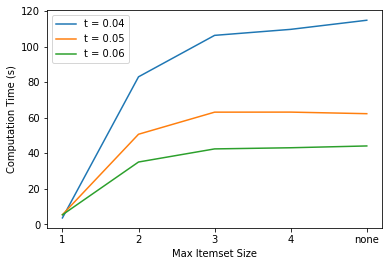

In [ ]:
vertical = sizes
x = timings[0.04]
y = timings[0.05]
z = timings[0.06]

plt.plot(vertical, x, label = "t = 0.04")
plt.plot(vertical, y, label = "t = 0.05")
plt.plot(vertical, z, label = "t = 0.06")

plt.xlabel("Max Itemset Size")
plt.ylabel("Computation Time (s)")

plt.legend()
plt.savefig("drive/MyDrive/amd_proj/timings.jpeg")
plt.show()

### Number of frequent itemsets as a function of max_itemset_size and threshold

In [ ]:
from tqdm import tqdm
sizes = [1,2,3,4,5]
result_length = {}

for size in tqdm(sizes):
  print(f"\nMax itemsize: {size}")
  result = len(apriori(subset, max_itemset_size=size, perc_threshold=0.02))
  result_length[size] = result
  print("====================\n")

  0%|          | 0/5 [00:00<?, ?it/s]


Max itemsize: 1


 20%|██        | 1/5 [00:15<01:02, 15.65s/it]



Max itemsize: 2


 40%|████      | 2/5 [06:41<11:40, 233.44s/it]



Max itemsize: 3


 60%|██████    | 3/5 [16:49<13:28, 404.49s/it]



Max itemsize: 4


 80%|████████  | 4/5 [27:23<08:15, 495.14s/it]



Max itemsize: 5


100%|██████████| 5/5 [38:07<00:00, 457.43s/it]

In [ ]:
result_length

{1: 628, 2: 2812, 3: 3664, 4: 3834, 5: 3861}

In [ ]:
result_length = {1: 628, 2: 2812, 3: 3664, 4: 3834, 5: 3861}

result = {}
prev_value = 0

for key, value in result_length.items():
    result_length[key] = value - prev_value
    prev_value = value


In [ ]:
result_length

{1: 628, 2: 2184, 3: 852, 4: 170, 5: 27}

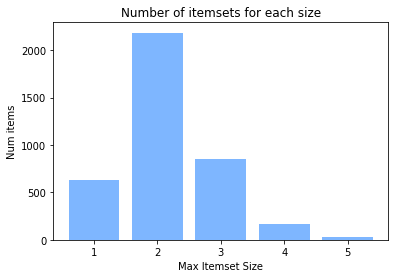

In [ ]:
plt.bar(result_length.keys(), result_length.values(),color = '#7EB6FF',width = 0.8)
plt.title("Number of itemsets for each size")
plt.xlabel("Max Itemset Size")
plt.ylabel("Num items")
plt.savefig("drive/MyDrive/amd_proj/size.jpeg")
plt.show()

### Market Basket Analysis: Confidence and Interest

In [ ]:
# Create a dictonary from the results, containing the support for each itemset
support_dict = [((t[0],), t[1]/len(subset)) if type(t[0])==str else (t[0], t[1]/len(subset)) for t in results ]
support_dict = {x:y for x,y in support_dict}

In [ ]:
# Create a dictionary for the confidence and one for the lift
confidence = {}
lift = {}

# For each key "UY" of the dictionary, comput the confidence and the lift of the 
# rule U => Y
for UY in support_dict:
  if len(UY) > 1:
    for Y in UY:
      # Remove Y from U
      U = list(U)
      U = tuple(U.remove(Y))

      # Compute the confidence as the support of the union U union Y divided by the
      # support of U
      confidence[U,Y] = support_dict[UY] / support_dict[U]

      # Compute the lift as the support of U union Y divided by the support of Y
      # and the support of U
      lift[x,y] = (support_dict[UY])/(support_dict[(Y, )]*support_dict[U])

In [ ]:
# Retrieve the rule with maximum confidence
max(confidence, key=confidence.get)

(('gel', 'weight'), 'molecular')

In [ ]:
# Retrieve the rule with maximum lift
max(lift, key=lift.get)

(('electrophoresis',), 'gel')